---


## `Testing Final Models and Feature Importance`


---

In [1]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from datetime import timedelta
from sklearn.metrics import mean_squared_log_error as msle

In [2]:
# read the dataset
data = pd.read_csv('final_data.csv')

In [3]:
# check for the null values
data.isna().sum().sum()

0

In [4]:
data.loc[0]

WEEK_END_DATE               2009-01-14
STORE_NUM                          367
UPC                         1111009477
BASE_PRICE                        1.57
FEATURE                              0
DISPLAY                              0
UNITS                               13
MANUFACTURER_1                       1
MANUFACTURER_2                       0
MANUFACTURER_3                       0
MANUFACTURER_4                       0
MANUFACTURER_5                       0
MANUFACTURER_6                       0
MANUFACTURER_7                       0
MANUFACTURER_8                       0
MANUFACTURER_9                       0
CATEGORY_1                           1
CATEGORY_2                           0
CATEGORY_3                           0
CATEGORY_4                           0
SUB_CATEGORY_1                       1
SUB_CATEGORY_2                       0
SUB_CATEGORY_3                       0
SUB_CATEGORY_4                       0
SUB_CATEGORY_5                       0
SUB_CATEGORY_6           

In [5]:
# drop the columns that are not required
data = data.drop(columns= ['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [6]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [7]:
week = data.WEEK_END_DATE.unique()

In [8]:
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['no_days_train_2'] = x_data['validate_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        

    df = pd.DataFrame.from_dict(model_set)
    df['no_days_train_1'] = df['no_days_train_1'] + timedelta(days=7)
    df['no_days_train_2'] = df['no_days_train_2'] + timedelta(days=7)
    return df    

In [9]:
validation_df(data, week, no_of_months=2, no_of_validation = 14)

,no_days_train_1,no_days_train_2,set_no,test_week,train_end_1,train_start_1,train_start_2,validate_week
0,56 days,56 days,set1,2011-09-28,2011-08-31,2011-07-13,2011-07-27,2011-09-14
1,56 days,56 days,set2,2011-09-21,2011-08-24,2011-07-06,2011-07-20,2011-09-07
2,56 days,56 days,set3,2011-09-14,2011-08-17,2011-06-29,2011-07-13,2011-08-31
3,56 days,56 days,set4,2011-09-07,2011-08-10,2011-06-22,2011-07-06,2011-08-24
4,56 days,56 days,set5,2011-08-31,2011-08-03,2011-06-15,2011-06-29,2011-08-17
5,56 days,56 days,set6,2011-08-24,2011-07-27,2011-06-08,2011-06-22,2011-08-10
6,56 days,56 days,set7,2011-08-17,2011-07-20,2011-06-01,2011-06-15,2011-08-03
7,56 days,56 days,set8,2011-08-10,2011-07-13,2011-05-25,2011-06-08,2011-07-27
8,56 days,56 days,set9,2011-08-03,2011-07-06,2011-05-18,2011-06-01,2011-07-20
9,56 days,56 days,set10,2011-07-27,2011-06-29,2011-05-11,2011-05-25,2011-07-13


In [10]:
# define a function to calculate the evaluation sets.
# this time we will include test set also
def get_evaluation_sets(data, df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['set_no'])
        # get the train data 1
        train_data_1 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_1']) & (data.WEEK_END_DATE <= df.loc[row]['train_end_1'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        # get the train data 2
        train_data_2 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_2']) & (data.WEEK_END_DATE <= df.loc[row]['validate_week'])]
        # get the test data
        test_data = data[data.WEEK_END_DATE == df.loc[row]['test_week']]
        evaluation_set.append((train_data_1, validation_data, train_data_2, test_data))
    return evaluation_set

In [11]:
# get the evaluation sets
evaluation_sets = get_evaluation_sets(data,
                                      validation_df(data,
                                                    week,
                                                    no_of_months= 2,
                                                    no_of_validation=14)
                                     )

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [12]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

---

***Define function to calculate results on the evaluation sets.***

---

In [13]:
def get_results_on_evaluation_set(eval_set, model):
    results = []
    set_n = 1
    for eval_data in tqdm(eval_set):
        
        x = {}
        train_data_1, validate, train_data_2, test = eval_data
        
        # separate the independent and target variables from train and valid
        train_data_1_x = train_data_1.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_1_y = train_data_1['UNITS']
        
        validate_x = validate.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        validate_y = validate['UNITS']
        
        train_data_2_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_2_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        
        # fit the model on the training data
        model_valid = model.fit(train_data_1_x, train_data_1_y)
        
        # predict the target on train and validate
        predict_train_1 = model_valid.predict(train_data_1_x).clip(min=0)
        predict_valid   = model_valid.predict(validate_x).clip(min=0)
                
        
        # fit the model on the training data
        model_test  = model.fit(train_data_2_x, train_data_2_y)
        
        # predict the target on train and test
        predict_train_2 = model_test.predict(train_data_2_x).clip(min=0)
        predict_test    = model_test.predict(test_x).clip(min=0)
        
        
        # calculate the rmsle on train and valid
        rmsle_train_1 = get_msle(train_data_1_y, predict_train_1)
        rmsle_valid   = get_msle(validate_y, predict_valid)
        
        # calculate the rmsle on train and test
        rmsle_train_2 = get_msle(train_data_2_y, predict_train_2)
        rmsle_test    = get_msle(test_y, predict_test)
        
        
        x['set_no'] = set_n
        set_n +=1
        x['rmsle_train_1'] = rmsle_train_1
        x['rmsle_valid'] = rmsle_valid
        x['rmsle_train_2'] = rmsle_train_2
        x['rmsle_test'] = rmsle_test
        results.append(x)
        
        
    return pd.DataFrame.from_dict(results)
        

In [14]:
# define function to get the best 10 feature importance plot
def get_feature_importance(eval_set, model):
    train_data_1, validate, train_data_2, test = eval_set
    
    train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_data_y = train_data_2['UNITS']
        
    test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    test_y = test['UNITS']
    
    model.fit(train_data_x, train_data_y)
    (pd.Series(model.feature_importances_, index=train_data_x.columns).nlargest(10).plot(kind='barh')) 


---

## `RANDOM FOREST`

---

In [15]:
### define randomforest model
model_rf = RandomForestRegressor(max_depth=10, n_estimators=175, random_state=0)

# calculate the results using the random forest
results_RFR = get_results_on_evaluation_set(evaluation_sets, model_rf)

100%|██████████| 14/14 [03:57<00:00, 17.05s/it]


In [49]:
results_RFR[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.354970,0.415476
1,0.357439,0.499669
2,0.365272,0.406321
3,0.352390,0.466678
4,0.348456,0.556271
5,0.353550,0.480295
6,0.344304,0.490637
7,0.339212,0.545311
8,0.334285,0.439274
9,0.337396,0.478067


In [47]:
# average rmsle
results_RFR[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.349474
rmsle_test       0.466220
dtype: float64

---

### `XGBOOST`
---

In [18]:
# define the xgboost model
model_XGB = xgb.XGBRegressor(n_estimators = 720,
                             subsample = 1,
                             max_depth = 4,
                             min_child_weight = 2,
                             gamma = 0,
                             learning_rate = 0.01,
                             n_jobs = 4,
                             random_state = 0,
                             objective ='reg:squarederror')

In [19]:
# calculate the results using xgboost
results_XGB = get_results_on_evaluation_set(evaluation_sets, model_XGB)

100%|██████████| 14/14 [02:20<00:00, 10.37s/it]


In [46]:
results_XGB[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.409002,0.428923
1,0.412636,0.479892
2,0.416334,0.405766
3,0.408288,0.474191
4,0.405199,0.537664
5,0.406760,0.477474
6,0.395314,0.456209
7,0.393476,0.538499
8,0.388115,0.432922
9,0.387916,0.467024


In [45]:
results_XGB[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.402990
rmsle_test       0.463813
dtype: float64

---

## `CATBOOST`

---

In [22]:
# read the data for the catboost model
catboost_data = pd.read_csv('catboost_data.csv')

In [23]:
# convert WEEK_END_DATE to datetime format
catboost_data.WEEK_END_DATE = pd.to_datetime(catboost_data.WEEK_END_DATE)

In [24]:
validation_df(catboost_data, week, no_of_months=2, no_of_validation=14)

,no_days_train_1,no_days_train_2,set_no,test_week,train_end_1,train_start_1,train_start_2,validate_week
0,56 days,56 days,set1,2011-09-28,2011-08-31,2011-07-13,2011-07-27,2011-09-14
1,56 days,56 days,set2,2011-09-21,2011-08-24,2011-07-06,2011-07-20,2011-09-07
2,56 days,56 days,set3,2011-09-14,2011-08-17,2011-06-29,2011-07-13,2011-08-31
3,56 days,56 days,set4,2011-09-07,2011-08-10,2011-06-22,2011-07-06,2011-08-24
4,56 days,56 days,set5,2011-08-31,2011-08-03,2011-06-15,2011-06-29,2011-08-17
5,56 days,56 days,set6,2011-08-24,2011-07-27,2011-06-08,2011-06-22,2011-08-10
6,56 days,56 days,set7,2011-08-17,2011-07-20,2011-06-01,2011-06-15,2011-08-03
7,56 days,56 days,set8,2011-08-10,2011-07-13,2011-05-25,2011-06-08,2011-07-27
8,56 days,56 days,set9,2011-08-03,2011-07-06,2011-05-18,2011-06-01,2011-07-20
9,56 days,56 days,set10,2011-07-27,2011-06-29,2011-05-11,2011-05-25,2011-07-13


In [25]:
# evaluation sets for the catboost model
catboost_evaluation_set = get_evaluation_sets(catboost_data,
                                              validation_df(catboost_data,
                                                            week,
                                                            no_of_months=2,
                                                            no_of_validation=14))

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [26]:
# indices of the catboost model
categorical_feature_indices = [1, 16, 17, 18, 19, 20, 21, 22, 23]

In [27]:
# define catboost model
model_CBR = CatBoostRegressor(n_estimators=1800,
                              l2_leaf_reg=3,
                              max_depth=8,
                              learning_rate= 0.075,
                              objective='RMSE',
                              verbose=False,
                              eval_metric='MSLE',
                              cat_features=categorical_feature_indices)

In [28]:
# calculate the results using the catboost model
results_CBR = get_results_on_evaluation_set(catboost_evaluation_set, model_CBR)

100%|██████████| 14/14 [27:15<00:00, 117.54s/it]


In [43]:
results_CBR[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.387403,0.447869
1,0.386485,0.493929
2,0.379700,0.408507
3,0.376091,0.468958
4,0.366734,0.538464
5,0.372218,0.486320
6,0.356649,0.437900
7,0.361327,0.529742
8,0.360224,0.451461
9,0.356200,0.473449


In [44]:
results_CBR[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.374783
rmsle_test       0.463126
dtype: float64

---

### `FEATURE IMPORTANCE`

---

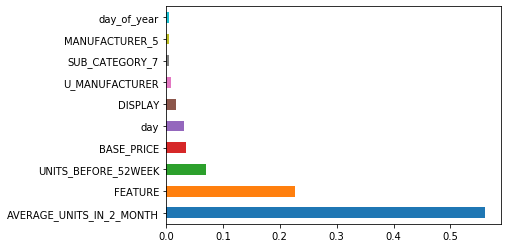

In [31]:
get_feature_importance(evaluation_sets[0], model_rf)

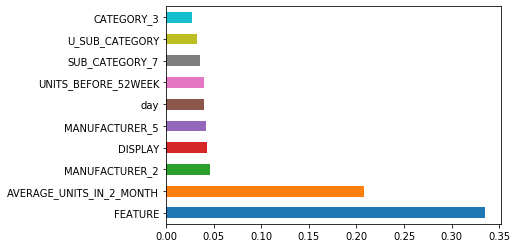

In [32]:
get_feature_importance(evaluation_sets[0], model_XGB)

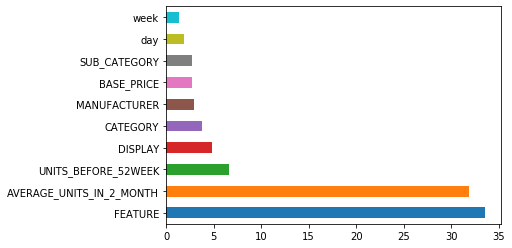

In [33]:
get_feature_importance(catboost_evaluation_set[0], model_CBR)

---

## `ENSEMBLE MODEL`


---



In [38]:
def get_score(model_result1, model_result2, weight=0.35):
    
    true1, prediction1 = model_result1
    true2, prediction2 = model_result2
    prediction = prediction1*weight + prediction2*(1 - weight)
    return get_msle(true1, prediction)

def get_ensemble_score(results_model1, results_model2, set_n) :
    
    train_1_model1, valid_model1 = results_model1
    
    train_1_model2, valid_model2 = results_model2
      
   
    x = {}
    x['set_n'] = set_n
    x['train_rmsle'] = get_score(train_1_model1, train_1_model2)
    x['test_rmsle']   = get_score(valid_model1, valid_model2)
        
    return x

def get_ensemble_results_on_evaluation_set(eval_set, eval_set_2, model1, model2):
    results = []
    set_n = 1
    for eval_data, eval_data_2 in tqdm(zip(eval_set,eval_set_2)):
        
        train_data_1, validate, train_data_2, test = eval_data
        
        
        train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        
        model = model1.fit(train_data_x, train_data_y)
        
        predict_train = model.predict(train_data_x).clip(min=0)
        predict_test   = model.predict(test_x).clip(min=0)
        
        results_model1 = ((train_data_y, predict_train),
                          (test_y, predict_test))
         
        
        ############################################################################
        
        train_data_1, validate, train_data_2, test = eval_data_2
        
        
        train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        
        model = model2.fit(train_data_x, train_data_y)
        
        predict_train = model.predict(train_data_x).clip(min=0)
        predict_test  = model.predict(test_x).clip(min=0)
        
        results_model2 = ((train_data_y, predict_train),
                          (test_y, predict_test))
        
        results.append(get_ensemble_score(results_model1, results_model2,set_n))
        set_n += 1
        
        
    return results

In [39]:
final_ensemble_results = get_ensemble_results_on_evaluation_set(evaluation_sets, 
                                                                catboost_evaluation_set, 
                                                                model_XGB,
                                                                model_CBR)



0it [00:00, ?it/s]

1it [00:39, 39.64s/it]

2it [01:19, 39.74s/it]

3it [01:59, 39.71s/it]

4it [02:39, 39.94s/it]

5it [03:20, 40.08s/it]

6it [04:00, 40.25s/it]

7it [04:41, 40.46s/it]

8it [05:23, 40.72s/it]

9it [06:03, 40.58s/it]

10it [06:43, 40.41s/it]

11it [07:23, 40.48s/it]

12it [08:02, 39.99s/it]

13it [08:41, 39.60s/it]

14it [09:21, 39.80s/it]

In [42]:
pd.DataFrame.from_dict(final_ensemble_results).mean()

set_n          7.500000
test_rmsle     0.455714
train_rmsle    0.379992
dtype: float64